In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# Tensorflow GPU setup

In [4]:
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)

else:
    print("Failed to detect a GPU.")


Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


# Tensor Functions


- Load images
- Convert to greyscale
- Ensure 256x256, and .jpg/.png/.jpeg
- Convert to tensor
- Apply mask
- Return tensor dataframe

In [4]:
def convert_to_grayscale_tensor(folder_path, num_images=1345, target_size=(256, 256)):
    image_tensors = []
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    for image_file in image_files[:num_images]:
        image_path = os.path.join(folder_path, image_file)
        image = load_img(image_path, color_mode='grayscale', target_size=target_size)  # Load as grayscale
        image_array = img_to_array(image) / 255.0  # Normalize pixel values to [0, 1]
        image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
        image_tensors.append(image_tensor.numpy().flatten())  # Flatten the tensor
    
    return image_tensors

In [5]:
def apply_masks_to_tensors(image_folder, mask_folder, num_images=1345, target_size=(256, 256)):
    
    image_tensors = convert_to_grayscale_tensor(image_folder, num_images, target_size)
    mask_files = [f for f in os.listdir(mask_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Sort masks to match images, assuming names are identical
    mask_files.sort()
    
    masked_tensors = []
    print("Applying mask:",mask_folder)
    for i, tensor in enumerate(image_tensors):
        
        if i >= len(mask_files):
            break
        mask_file = mask_files[i]
        mask_path = os.path.join(mask_folder, mask_file)
        mask_image = load_img(mask_path, color_mode='grayscale', target_size=target_size)
        mask_array = img_to_array(mask_image) / 255.0  # Normalize pixel values to [0, 1]
        mask_tensor = tf.convert_to_tensor(mask_array, dtype=tf.float32)
        
        # Apply mask: element-wise multiplication
        masked_array = tensor.reshape(target_size[0], target_size[1]) * mask_tensor.numpy().reshape(target_size[0], target_size[1])
        
        # Flatten and append
        masked_tensors.append(masked_array.flatten())
    
    return masked_tensors

In [6]:
base_folder = 'Images'

# List all subdirectories (folders)
folders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]

# Dictionary to hold DataFrames for each folder
dataframes = {}

# Process each folder
for folder_name in folders:
    image_folder_path = os.path.join(base_folder, folder_name, 'images')
    mask_folder_path = os.path.join(base_folder, folder_name, 'masks')
    
    print(f"Processing folder: {image_folder_path}")  # Debug: print current folder being processed
    
    # Apply masks to images in the folder
    tensors = apply_masks_to_tensors(image_folder_path, mask_folder_path)
    
    # Check if tensors are empty
    if not tensors:
        print(f"No tensors created for folder: {image_folder_path}")
        continue
    
    # Create a DataFrame from the tensors
    df = pd.DataFrame(tensors)
    
    # Add a column for the folder name as the label
    df['Label'] = folder_name.lower()  # e.g., 'covid', 'pneumonia', etc.
    
    # Store the DataFrame in the dictionary
    dataframes[folder_name] = df

# Concatenate all DataFrames into a single DataFrame if needed
df = pd.concat(dataframes.values(), ignore_index=True)
print("Complete")

Processing folder: Images\Covid\images
Applying mask: Images\Covid\masks
Processing folder: Images\Lung_Opacity\images
Applying mask: Images\Lung_Opacity\masks
Processing folder: Images\Normal\images
Applying mask: Images\Normal\masks
Processing folder: Images\Viral_Pneumonia\images
Applying mask: Images\Viral_Pneumonia\masks
Complete


In [7]:
df

,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,covid
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,covid
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,covid
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,covid
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,viral_pneumonia
5376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,viral_pneumonia
5377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,viral_pneumonia
5378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,viral_pneumonia


In [8]:
# Split data into features and labels
X = df.drop('Label', axis=1).values
y = df['Label'].values


# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.4, random_state=42)

# Evaluation Function

In [10]:
def metrics(model, X_test, y_test, label_encoder, history):
    # Make predictions
    y_pred_proba = model.predict(X_test)  # Predict probabilities for ROC
    y_pred_classes = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class labels

    # Plot loss values over epochs
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)  # Validation loss might not be available

    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    if val_loss is not None:
        plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss Values Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes, labels=np.arange(len(label_encoder.classes_)))
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve
    y_test_binarized = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
    fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
    roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average='macro')
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # Classification Report
    report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
    print("Classification Report:\n", report)

# Baseline Model

In [12]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # For integer labels
              metrics=['accuracy'])

In [13]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.4)

Epoch 1/20
31/31 [==============================] - 3s 93ms/step - loss: 3.4295 - accuracy: 0.3450 - val_loss: 1.2336 - val_accuracy: 0.4272
Epoch 2/20
31/31 [==============================] - 3s 88ms/step - loss: 1.4007 - accuracy: 0.4468 - val_loss: 1.0882 - val_accuracy: 0.5364
Epoch 3/20
31/31 [==============================] - 3s 89ms/step - loss: 1.1840 - accuracy: 0.4628 - val_loss: 1.0415 - val_accuracy: 0.5611
Epoch 4/20
31/31 [==============================] - 3s 89ms/step - loss: 1.1361 - accuracy: 0.5103 - val_loss: 0.9702 - val_accuracy: 0.5782
Epoch 5/20
31/31 [==============================] - 3s 89ms/step - loss: 1.0461 - accuracy: 0.5465 - val_loss: 0.9219 - val_accuracy: 0.5975
Epoch 6/20
31/31 [==============================] - 3s 88ms/step - loss: 1.0183 - accuracy: 0.5496 - val_loss: 0.9240 - val_accuracy: 0.6014
Epoch 7/20
31/31 [==============================] - 3s 88ms/step - loss: 1.0070 - accuracy: 0.5429 - val_loss: 0.9441 - val_accuracy: 0.5991
Epoch 8/20
31

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

68/68 [==============================] - 1s 15ms/step - loss: 0.8261 - accuracy: 0.6571
Test Loss: 0.8261
Test Accuracy: 0.6571


68/68 [==============================] - 1s 15ms/step


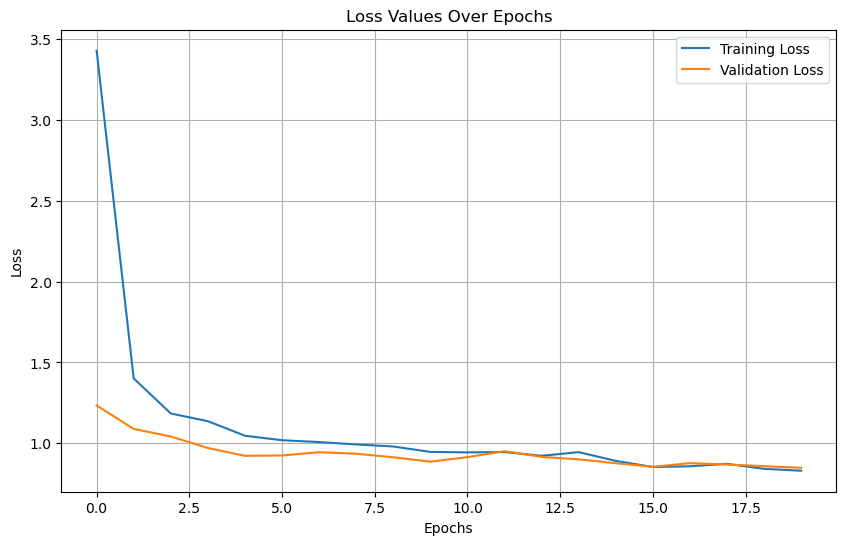

<Figure size 1000x800 with 0 Axes>

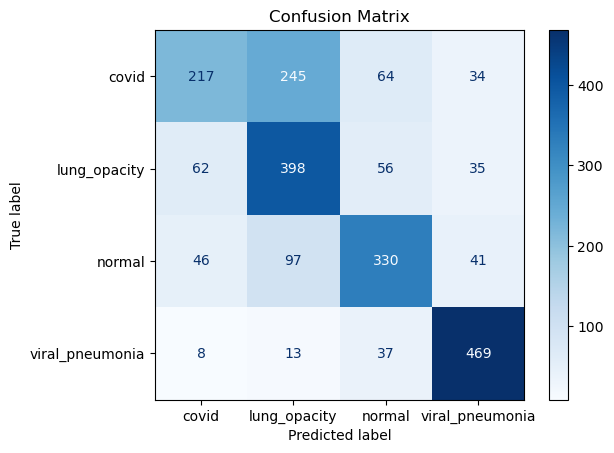

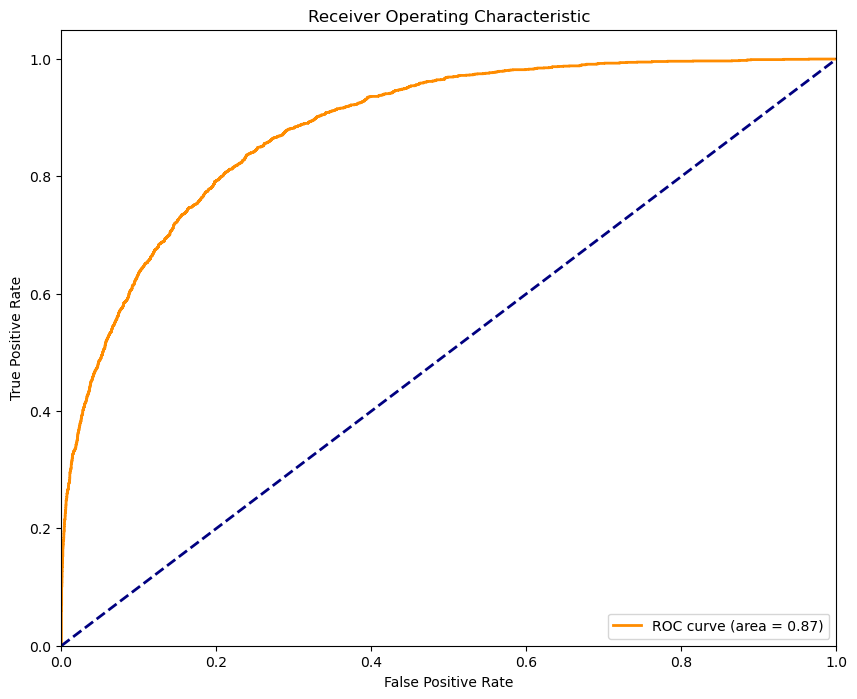

Classification Report:
                  precision    recall  f1-score   support

          covid       0.65      0.39      0.49       560
   lung_opacity       0.53      0.72      0.61       551
         normal       0.68      0.64      0.66       514
viral_pneumonia       0.81      0.89      0.85       527

       accuracy                           0.66      2152
      macro avg       0.67      0.66      0.65      2152
   weighted avg       0.67      0.66      0.65      2152



In [15]:
metrics(model, X_test, y_test, label_encoder, history)

# ReduceLROnPlateau

In [17]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Number of classes
])

# Compile the model with a custom learning rate
learning_rate = 0.001  # Example learning rate, you can adjust this value
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',  # For integer labels
              metrics=['accuracy'])

In [18]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.0000001)

history = model.fit(X_train, y_train, epochs=10, batch_size=16, 
                    validation_split=0.2, callbacks=[lr_reduction])

Epoch 1/10
162/162 [==============================] - 11s 68ms/step - loss: 4.0261 - accuracy: 0.2789 - val_loss: 1.3364 - val_accuracy: 0.3313 - lr: 0.0010
Epoch 2/10
162/162 [==============================] - 11s 67ms/step - loss: 1.4244 - accuracy: 0.3164 - val_loss: 1.3236 - val_accuracy: 0.4799 - lr: 0.0010
Epoch 3/10
162/162 [==============================] - 11s 67ms/step - loss: 1.3316 - accuracy: 0.3664 - val_loss: 1.1841 - val_accuracy: 0.4752 - lr: 0.0010
Epoch 4/10
162/162 [==============================] - 11s 70ms/step - loss: 1.2948 - accuracy: 0.4016 - val_loss: 1.1292 - val_accuracy: 0.5108 - lr: 0.0010
Epoch 5/10
162/162 [==============================] - 11s 68ms/step - loss: 1.2181 - accuracy: 0.4314 - val_loss: 1.0842 - val_accuracy: 0.4954 - lr: 0.0010
Epoch 6/10
162/162 [==============================] - 11s 66ms/step - loss: 1.1952 - accuracy: 0.4419 - val_loss: 1.0511 - val_accuracy: 0.4969 - lr: 0.0010
Epoch 7/10
162/162 [==============================] - 11s 

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

68/68 [==============================] - 1s 15ms/step - loss: 1.0397 - accuracy: 0.5260
Test Loss: 1.0397
Test Accuracy: 0.5260


68/68 [==============================] - 1s 15ms/step


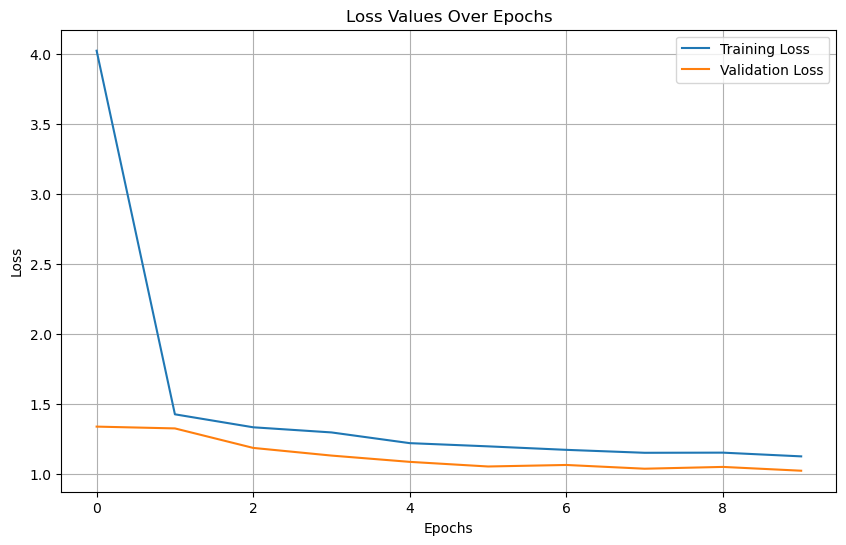

<Figure size 1000x800 with 0 Axes>

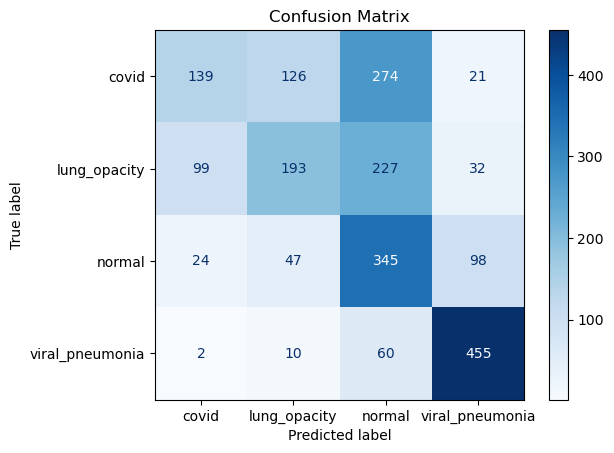

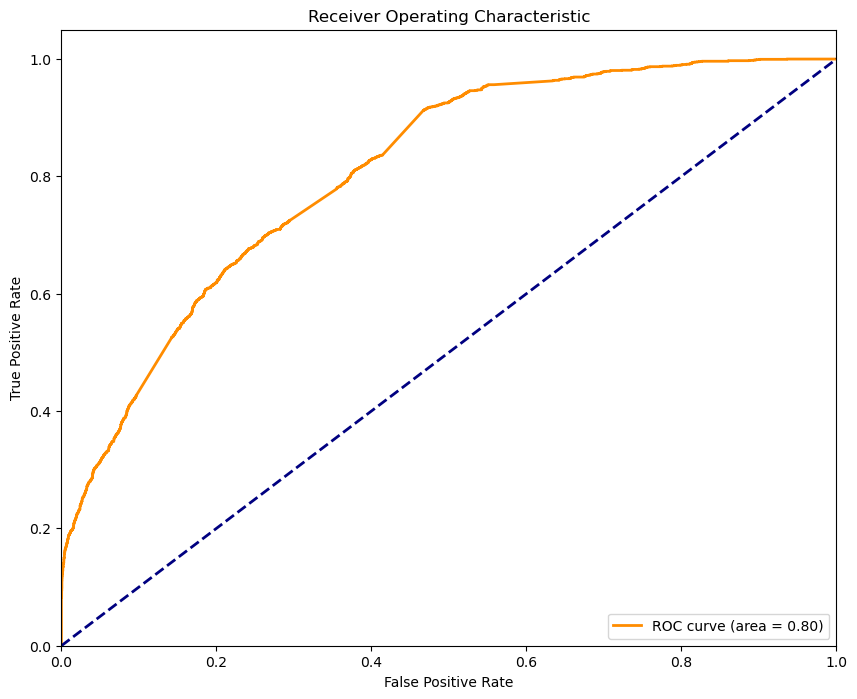

Classification Report:
                  precision    recall  f1-score   support

          covid       0.53      0.25      0.34       560
   lung_opacity       0.51      0.35      0.42       551
         normal       0.38      0.67      0.49       514
viral_pneumonia       0.75      0.86      0.80       527

       accuracy                           0.53      2152
      macro avg       0.54      0.53      0.51      2152
   weighted avg       0.54      0.53      0.51      2152



In [20]:
metrics(model, X_test, y_test, label_encoder, history)